<h1 style='display:flex; align-items:center;'>
  <img src='assets/AiMed_logo.png' alt='AiMedOrchestra Logo' width='60' style='margin-right:12px;'>
  AiMedOrchestra – Interactive Demo
</h1>

Welcome to the conversational AI demo for AiMedOrchestra. Use the chat box below to interact with the orchestrator naturally.

Welcome!  This notebook lets you:

1. **Visualise** the LangGraph router that connects all 11 specialist agents.  
2. **Chat inline** with the unified `aimedorchestraagent` (Gradio UI).  
3. **Run a few light‑weight smoke tests** to check key agents.

> **Tip:** Heavy models are *lazy‑loaded*, so memory usage stays low unless you
call a specific agent.


In [1]:
import os

# Disable unused modules
os.environ.setdefault("AIMED_DISABLE_DRUG_DISCOVERY", "1")
os.environ.setdefault("AIMED_DISABLE_IMAGING", "1")

# Threading and parallelism limits
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# Hardware/runtime tweaks
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")

# GUI / native libs stability
os.environ.setdefault("QT_QPA_PLATFORM", "offscreen")
os.environ.setdefault("OPENCV_OPENCL_RUNTIME", "disabled")


'disabled'

In [2]:
# Import orchestrator with robust fallback
import sys, os, json
from pathlib import Path

# Try normal import first
try:
    from aimedorchestra.orchestrator.agent import aimedorchestraAgent
except Exception as e:
    # Fallback: add repo root and its parent to sys.path
    here = Path(".").resolve()
    sys.path.insert(0, str(here))
    sys.path.insert(0, str(here.parent))
    from aimedorchestra.orchestrator.agent import aimedorchestraAgent

orch = aimedorchestraAgent()
print("✅ Orchestrator ready.")

⚠️  SDV not installed — using Faker-based DataSynthesizer fallback.
✅ Orchestrator ready.


### 🔬 Quick Self Test
Run this cell to verify all agents can respond to a minimal request. It uses the orchestrator's built‑in `self test` intent and returns a JSON report.

In [3]:
# Light Self Test — FAST mode (skips heavy HF models), with warning suppression
import os, json, traceback, warnings

# Suppress common HF warnings & set truncation=True automatically
try:
    from transformers.utils import logging as hf_logging
    hf_logging.set_verbosity_error()
    from transformers import PreTrainedTokenizerBase
    _orig_call = PreTrainedTokenizerBase.__call__
    def _patched_call(self, *args, **kwargs):
        if 'max_length' in kwargs and 'truncation' not in kwargs:
            kwargs['truncation'] = True
        return _orig_call(self, *args, **kwargs)
    if getattr(PreTrainedTokenizerBase.__call__, "_aimed_patched", False) is False:
        PreTrainedTokenizerBase.__call__ = _patched_call
        PreTrainedTokenizerBase.__call__._aimed_patched = True  # type: ignore[attr-defined]
except Exception:
    pass

warnings.filterwarnings("ignore", message=r".*Truncation was not explicitly activated.*")
warnings.filterwarnings("ignore", message=r".*copy construct from a tensor.*")
warnings.filterwarnings("ignore", message=r".*pad_token_id.*")

# Guard orchestrator
try:
    orch
except NameError:
    from aimedorchestra.orchestrator.agent import aimedorchestraAgent
    orch = aimedorchestraAgent()

# Define tests (will skip heavy ones in FAST mode)
tests = {
    "data_synthesis": "create 2 synthetic patients",
    "diagnostics": "diagnose a 55 yo female with chest pain and cough",
    "diet_planner": "diet plan for a 60 yo male with diabetes",
    "literature_surveillance": "search literature for lung cancer immunotherapy",
    "clinical_trial_matching": "find trials for a 65 yo male with lung cancer in Boston",
    "mental_health": "I feel worried about my diagnosis",
    "treatment_optimization": "treatment plan for a 50 yo female with hypertension",
}

FAST = os.environ.get("AIMED_FAST_SELFTEST", "1") == "1"
skipped = []
if FAST:
    for k in ["literature_surveillance", "mental_health"]:
        if k in tests:
            skipped.append(k)
            tests.pop(k, None)

report = {"__skipped__": skipped, "__fast__": FAST}
for k, cmd in tests.items():
    try:
        out = orch.route(cmd)
        report[k] = {"ok": True, "result": out}
    except Exception as e:
        report[k] = {"ok": False, "error": f"{e}"}

print(json.dumps(report, indent=2))

🧪 DataSynthesisAgent initialised (Faker mode).
{
  "__skipped__": [
    "literature_surveillance",
    "mental_health"
  ],
  "__fast__": true,
  "data_synthesis": {
    "ok": true,
    "result": "\"   age  gender   bmi conditions\\n0   25    Male  26.6       None\\n1   77  Female  41.9   Diabetes\""
  },
  "diagnostics": {
    "ok": true,
    "result": "\"Prevent the onset of bleeding and prolong the duration of symptoms\\n\\nAs with other procedures, you should monitor blood sugar levels. It is important to monitor blood glucose levels before and during the treatment period. We recommend that patients refrain from urinating, vomiting or urinating on their own.\\n\\nPrevent the onset of hypoglycemia, which can occur in patients with low blood sugar, and to prevent a loss of a person's ability to function.\\n\\nPrevent the occurrence of hypoglycemia in patients with other diabetes and other hypoglycemic conditions\\n\\nThe following principles should be observed:\\n\\nFor patients with

In [4]:
# Light Self Test: uses only fast, dependency-light agents.
# Skips heavy tools (RDKit/OpenCV/etc.).
import os, json, traceback

# Ensure heavy agents are disabled at runtime (no-op if not present)
os.environ.setdefault("AIMED_DISABLE_DRUG_DISCOVERY", "1")
os.environ.setdefault("AIMED_DISABLE_IMAGING", "1")

tests = {
    "data_synthesis": "create 2 synthetic patients",
    "diagnostics": "diagnose a 55 yo female with chest pain and cough",
    "diet_planner": "diet plan for a 60 yo male with diabetes",
    "literature_surveillance": "search literature for lung cancer immunotherapy",
    "clinical_trial_matching": "find trials for a 65 yo male with lung cancer in Boston",
    "mental_health": "I feel worried about my diagnosis",
    "treatment_optimization": "treatment plan for a 50 yo female with hypertension",
}

report = {}
for pkg, cmd in tests.items():
    try:
        out = orch.route(cmd)
        report[pkg] = {"ok": True, "result": out}
    except Exception as e:
        report[pkg] = {"ok": False, "error": f"{e}", "trace": traceback.format_exc()}

print(json.dumps(report, indent=2))


{
  "data_synthesis": {
    "ok": true,
    "result": "\"   age gender   bmi conditions\\n0   27   Male  21.9   Diabetes\\n1   22   Male  17.6       None\""
  },
  "diagnostics": {
    "ok": true,
    "result": "\"You are an experienced clinician writing a concise diagnostic impression. Patient information: [{'age': 55,'sex': 'female','symptoms': ['chest pain', 'cough']}, {'age': 56,'sex': 'female','symptoms': ['cough','myalgia', 'chest pain']}]\\n\\nWhen you have completed the treatment program, you will have completed a survey of your patients and will have been asked how often you have had the medications.\\n\\nIf you have a sample of patients that are using the medications, the results will be taken from the last survey conducted by their physicians.\\n\\nIf you have received a list of the medications you are taking, the results will be taken from the last survey conducted by your physician.\\n\\nYou may have received a list of the medications you are taking, but you will be requir

## 1  Visualise the routing graph

The cell below renders the router graph and saves it to *assets/router.png*.
If Graphviz isn’t installed, raw Mermaid text will be printed instead.


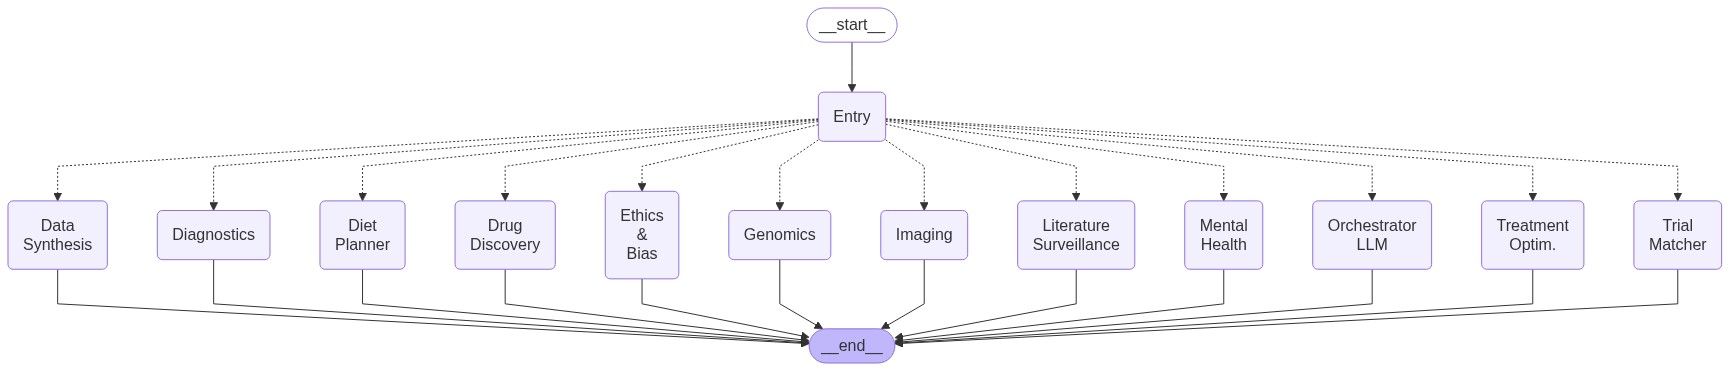

✅ Router graph saved to assets/router.png


In [5]:
from graph import show_mermaid_png
show_mermaid_png()

## 2  Light‑weight agent smoke tests

The snippets below run quickly (no big CNN or LLM weights).

In [6]:
from aimedorchestra.agents.clinical_trial_matching.agent import TrialMatchingAgent

def pretty_trials(trials: list[dict], max_rows: int | None = None) -> str:
    rows = trials if max_rows is None else trials[:max_rows]
    out  = []
    for t in rows:
        out.append(
            f"** {t['title']} **  \n"
            f"ID: `{t['id']}` | Phase: {t.get('phase','–')} | Condition: {t['condition']}  \n"
            f"Age {t['min_age']}-{t['max_age']} | Locations: {', '.join(t['locations'])}  \n"
            f"{t['summary']}  \n"
            f"[clinicaltrials.gov]({t['url']})"
        )
        out.append("")                 # blank line as separator
    return "\n".join(out)

tm      = TrialMatchingAgent(trials_path="data/trials.json")
matches = tm.match({"age": 50, "conditions": ["Diabetes"]})

print(pretty_trials(matches, max_rows=3))


** Novel GLP-1 Trial **  
ID: `T1001` | Phase: Phase 3 | Condition: Diabetes  
Age 30-65 | Locations: New York, NY  
Evaluates efficacy and safety of a next-generation GLP-1 receptor agonist in adults with Type 2 Diabetes.  
[clinicaltrials.gov](https://clinicaltrials.gov/ct2/show/NCT000T1001)

** Metformin for Type 2 Diabetes **  
ID: `Trial123` | Phase: Phase 3 | Condition: Diabetes  
Age 18-65 | Locations: Multi-site USA  
A study to evaluate the effectiveness of Metformin in adults with Type 2 Diabetes.  
[clinicaltrials.gov](https://clinicaltrials.gov/ct2/show/NCT00000000)



In [7]:
# Minimal quick check via orchestrator (keeps deps light)
print(orch.route("create 2 synthetic patients"))

"   age  gender   bmi conditions\n0   65  Female  29.9       None\n1   60    Male  24.0       None"


In [8]:
# Optional ethics check (kept simple)
print(orch.route("do an ethics check on these logs: [\"2025-08-05 patient_123 outcome=error\", \"2025-08-05 patient_124 outcome=ok\"]"))

{
  "message": "Try: 'create two synthetic patients', 'diagnose the patient with chest pain', 'find clinical trials for lung cancer', or 'run full pipeline on {\"age\":60, \"sex\":\"male\"}'."
}


# 🗣️ AiMedOrchestra — Conversational Chat
Type natural language below (e.g., *create two synthetic patients*, *diagnose a 55 yo female with chest pain*, *find clinical trials for lung cancer near Boston*, or *run full pipeline on {"age":60, "sex":"male"}*).

In [9]:
# Chat UI (tries ipywidgets, falls back to Gradio). Wait until the input box appears.
import json, traceback

def run_widgets_ui() -> bool:
    try:
        import ipywidgets as widgets
        from IPython.display import display, clear_output

        chat_box = widgets.Output(layout={'border': '1px solid #ddd', 'height':'360px', 'overflow_y':'auto', 'padding':'8px'})
        inp = widgets.Text(placeholder='Type a message (e.g., "create two synthetic patients")', layout=widgets.Layout(width="70%"))
        send_btn = widgets.Button(description='Send')
        clear_btn = widgets.Button(description='Clear')

        def render_message(role, content):
            with chat_box:
                if role == 'user':
                    print(f"🧑 {content}")
                else:
                    try:
                        obj = json.loads(content)
                        print(json.dumps(obj, indent=2))
                    except Exception:
                        print(content)

        def on_send(_):
            text = inp.value.strip()
            if not text:
                return
            render_message('user', text)
            inp.value = ''
            try:
                resp = orch.route(text)
            except Exception as e:
                resp = json.dumps({'error': str(e)})
            render_message('assistant', resp)

        def on_clear(_):
            chat_box.clear_output()

        send_btn.on_click(on_send)
        inp.on_submit(on_send)
        clear_btn.on_click(on_clear)

        display(widgets.VBox([chat_box, widgets.HBox([inp, send_btn, clear_btn])]))
        return True
    except Exception as e:
        print("ipywidgets not available or failed; falling back to Gradio.", e)
        return False

def run_gradio_ui():
    try:
        import gradio as gr
        def chat_fn(message, history):
            try:
                reply = orch.route(message)
                try:
                    obj = json.loads(reply)
                    reply = json.dumps(obj, indent=2)
                except Exception:
                    pass
                return reply
            except Exception as e:
                return f"Error: {e}"

        gr.ChatInterface(
            fn=chat_fn,
            title="AiMedOrchestra — Quick Chat",
            description="Wait until the input box appears, then type."
        ).launch(share=False, inline=True)
    except Exception as e:
        print("Gradio failed to launch:", e)

if not run_widgets_ui():
    run_gradio_ui()

/var/folders/60/vjq018q12kz_37fwrg6swy0r0000gn/T/ipykernel_52407/3411289083.py:41: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  inp.on_submit(on_send)
